### Imports

In [1]:
from importlib import reload
import numpy as np
import networkx as nx
import plotly
import pandas as pd
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, gc, utils
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
print("tensorflow version:", tf. __version__)
print("plotly version:", plotly.__version__)
print("Networkx version:", nx.__version__)
# tf.config.list_physical_devices()

tensorflow version: 2.10.1
plotly version: 5.23.0
Networkx version: 3.2.1


### Model selection

In [2]:
second_TGCNN_layer = True
demo = True

include_drugs = True
max_timesteps=100

stride = 1
filter_size = 4

run_name='hip_1999_to_one_year_advance_model'
years_in_advance = "5"

if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
hip_or_knee = 'hip'

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=16, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

In [3]:
# Generate individual data for the model
input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)

dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0)
logits = model(input_4d, demo_tensor, training=False)

grads = model.dy_du_branch1
print(grads.shape)

(1, 16, 97)


### Plot the gradient values

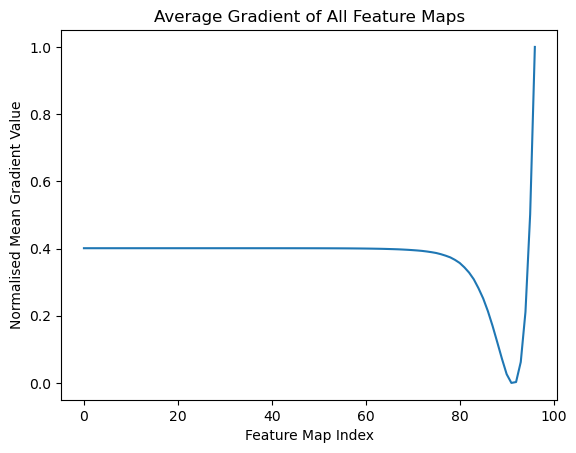

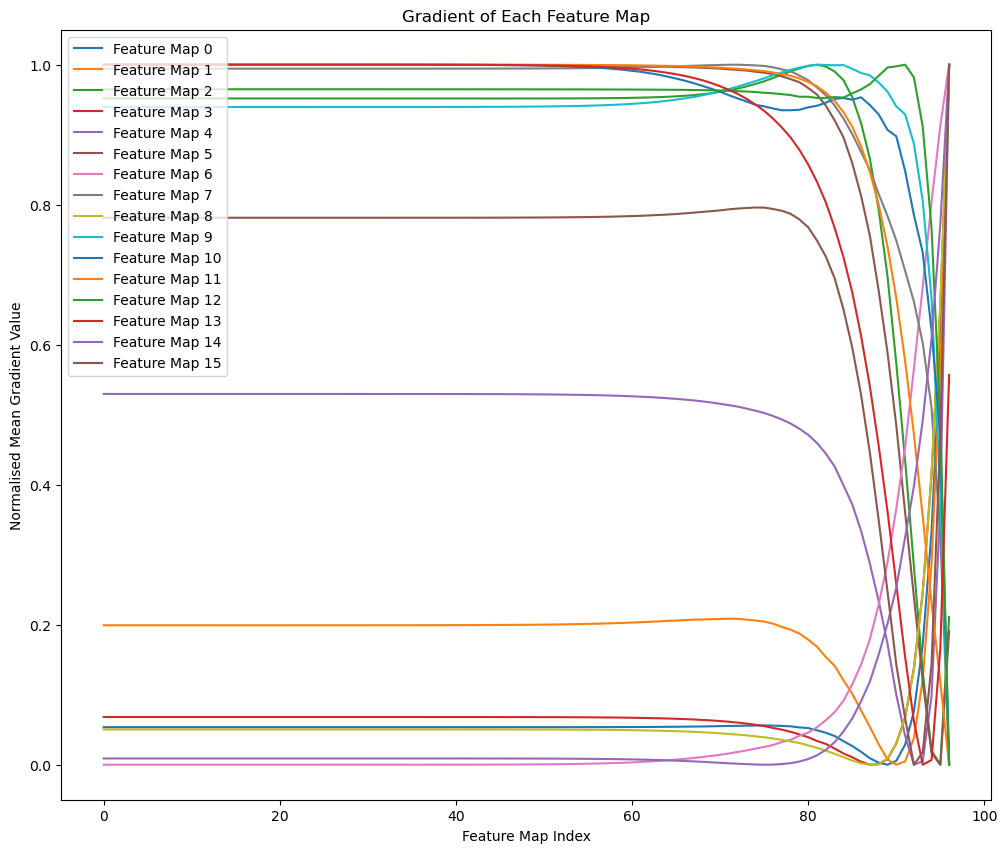

In [4]:
# Branch 1

norm_features = plot_feature_value.plot_ave_grad_all_f_maps(grads)

plot_feature_value.plot_indv_grad_f_maps(grads)

### Plotly/NetworkX Grad-CAM graph

In [20]:
reload(gc)

<module 'src.gc' from 'c:\\Users\\alexg\\OneDrive - University of Leeds\\explainable_TGCNN\\src\\gc.py'>

In [21]:
relu = True

# Get the entire patient's history in a DataFrame
edges_df = graph_plot.create_edges_df_gc(dense_tensor)

# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())

pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

l_map = gc.calc_local_map(model, grads, only_pos=relu, filt_num=None)

timestep_ave_grad_df = gc.calc_timestep_weights(stride, filter_size, l_map, max_timesteps)

read_code_pos_df = gc.map_read_code_labels(pos_df, read_code_map_df, timestep_ave_grad_df)

edge_pos_df = gc.create_edge_pos_df(edges_df, pos_df)

if relu == True:
    plot_name = 'all_filters_grad_cam_relu'
else:
    plot_name = 'all_filters_grad_cam_abs'

gc.plot_gradcam_plotly(edge_pos_df, pos_df, read_code_pos_df, years_in_advance, logits, outcome, plot_name, html_open=False)

#### Heatmap

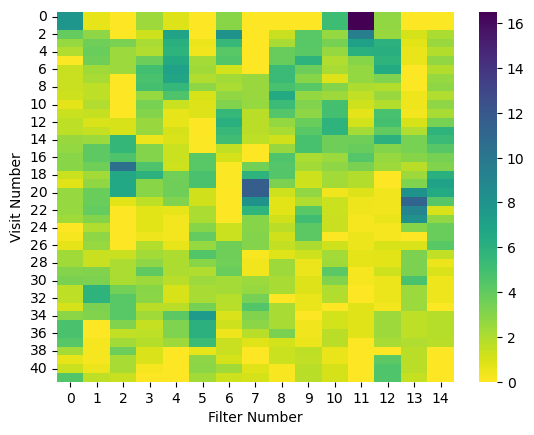

In [ ]:
# Loop through all filters and build a heatmap
heatmap_df = pd.DataFrame()
for i in range(1, 16):
    relu = True

    # Get the entire patient's history in a DataFrame
    edges_df = graph_plot.create_edges_df_gc(dense_tensor)

    # Get the node positions for the graph
    pos_df = graph_plot.create_position_df_gc(edges_df)
    pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
    pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

    l_map = gc.calc_local_map(model, grads, only_pos=relu, filt_num=i)

    timestep_ave_grad_df = gc.calc_timestep_weights(stride, filter_size, l_map, max_timesteps)

    read_code_pos_df = gc.map_read_code_labels(pos_df, read_code_map_df, timestep_ave_grad_df)
    #print(read_code_pos_df)
    # remove any rows with duplicate v number in node column
    df_unique = read_code_pos_df.drop_duplicates(subset='x', keep=False)

    heatmap_df[f'col_{i}'] = df_unique['perc_timestep_infl']
    
    #break
heatmap_array = heatmap_df.to_numpy()
sns.heatmap(heatmap_array, annot=False, cmap='viridis_r')
plt.ylabel('Visit Number')
plt.xlabel('Filter Number')

# Show the heatmap
plt.show()


#### Randomly add a connect node and see how percentage influence changes

In [72]:
# import random
# random_row_i = random.randint(0, len(edges_df) - 1)

# rows_to_copy = edges_df.iloc[random_row_i:random_row_i+2].copy()



# # Modify the end_node of the first copied row
# rows_to_copy.iloc[0, edges_df.columns.get_loc('end_node')] = '999_' + rows_to_copy.iloc[0]['end_node'].split('_', 1)[1] 
# rows_to_copy.iloc[0, edges_df.columns.get_loc('time_between')] = np.random.random()

# # Modify the start_node of the second copied row
# rows_to_copy.iloc[1, edges_df.columns.get_loc('start_node')] = '999_' + rows_to_copy.iloc[1]['start_node'].split('_', 1)[1]
# rows_to_copy.iloc[1, edges_df.columns.get_loc('time_between')] = np.random.random()

# # Append the modified rows to the DataFrame
# p_edges_df = pd.concat([edges_df, rows_to_copy], ignore_index=True)
# p_edges_df

In [79]:
reload(create_fake_patients)
relu= True
# Loop through each patient, run the original graph (once) then loop through the modified graphs with psuedo nodes

sensitivity_list = []
for pat in range(2):
    input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0) # REPLACE WITH CV_PATIENTS AND PAT NUMBER

    dense_tensor = tf.sparse.to_dense(input_3d)
    dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
    dense_tensor = np.flip(dense_tensor, axis=0)
    logits = model(input_4d, demo_tensor, training=False)

    grads = model.dy_du_branch1

    # Get the entire patient's history in a DataFrame
    edges_df = graph_plot.create_edges_df_gc(dense_tensor)

    # Get the node positions for the graph
    pos_df = graph_plot.create_position_df_gc(edges_df)
    pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())

    pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

    l_map = gc.calc_local_map(model, grads, only_pos=relu, filt_num=None)

    timestep_ave_grad_df = gc.calc_timestep_weights(stride, filter_size, l_map, max_timesteps)

    read_code_pos_df = gc.map_read_code_labels(pos_df, read_code_map_df, timestep_ave_grad_df)

    v_mod_list, v_orig_list = [], []
    for i in range(2):
        # Generate individual data for the model
        input_3d, input_4d, demo_tensor, outcome, outcome_bin, visit_num = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0, add_p_node=True) # REPLACE WITH CV_PATIENTS AND PAT NUMBER

        dense_tensor = tf.sparse.to_dense(input_3d)
        dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
        dense_tensor_p = np.flip(dense_tensor, axis=0)
        logits = model(input_4d, demo_tensor, training=False)

        grads = model.dy_du_branch1

        # Get the entire patient's history in a DataFrame
        p_edges_df = graph_plot.create_edges_df_gc(dense_tensor_p)

        # Get the node positions for the graph
        p_pos_df = graph_plot.create_position_df_gc(p_edges_df)
        p_pos_list = graph_plot.generate_pos_sequence(p_pos_df['max_codes_per_visit'].max())

        p_pos_df = graph_plot.map_y_coord_to_node(p_pos_df, p_pos_list)

        p_l_map = gc.calc_local_map(model, grads, only_pos=relu, filt_num=None)

        p_timestep_ave_grad_df = gc.calc_timestep_weights(stride, filter_size, p_l_map, max_timesteps)

        p_read_code_pos_df = gc.map_read_code_labels(p_pos_df, read_code_map_df, p_timestep_ave_grad_df)

        # get the difference in the percentage influence on the timestep with and without the psuedo node
        mod_visit_infl = p_read_code_pos_df[p_read_code_pos_df['x']==visit_num]['perc_timestep_infl']
        #print(visit_num)
        #print("With fake node:")
        #print(p_read_code_pos_df)
        #print(mod_visit_infl)
        v_mod = mod_visit_infl.iloc[0]
        #print(v_mod)
        #print(read_code_pos_df)
        #print("Without fake node:")
        #print(read_code_pos_df)
        #print(read_code_pos_df[read_code_pos_df['x']==visit_num])
        orig_visit_infl = read_code_pos_df[read_code_pos_df['x']==visit_num]['perc_timestep_infl']
        #print(orig_visit_infl)
        v_orig = orig_visit_infl.iloc[0]

        v_mod_list.append(v_mod)
        v_orig_list.append(v_orig)



    l1_norm = np.sum(np.abs(np.array(v_mod_list) - np.array(v_orig_list)))
    ave_l1_norm = l1_norm / 50
    #print(ave_l1_norm)
    sensitivity_list.append(ave_l1_norm)
print(f"Sensitivity mean +- std: {np.mean(sensitivity_list)}$\pm${np.std(sensitivity_list)}")




[333, 313, 37]
[256, 58, 47]
[394, 189, 98]
[209, 360, 89]


IndexError: single positional indexer is out-of-bounds

In [27]:
v_mod_list

[3.1214457, 6.8358]